# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

Team Members #78:

* Carlos Pano Hernandez - A01066264
* Emiliano Palafox Ruiz - A01796609
* Marie Kate Palau Andrade - A01705711
* Carlos Daniel Pacheco Pérez - A01566821

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 5 or 6 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

### 1. Libraries and dependencies

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#only if you have jupyterthemes
# from jupyterthemes import jtplot
# jtplot.style()

In [2]:
! pip install torchvision
import torchvision
import torchvision.transforms as transforms


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 2. Download Cifar10 dataset
First, we download and prepares the ***CIFAR-10 image dataset*** for training, validation, and testing in PyTorch. We define the dataset sizes, batch size, and image preprocessing steps using ToTensor() and normalization with CIFAR-10 mean and standard deviation values. Then, we loads the dataset using datasets.CIFAR10, automatically downloading it to DATA_PATH if needed.

Finally, the code verifies the dataset and batch configuration and iterates through the training loader to print example batches of images (x) and labels (y).

In [3]:
torch.cuda.is_available()

True

In this section, we implemented *Data Augmentation techniques* (RandomHorizontalFlip and RandomCrop) exclusively for the training set. The goal is to artificially increase the diversity of the dataset, forcing the network to learn invariant features (such as the shape of an object) instead of memorizing exact pixel positions. We are training with a 'harder exam' so that the model generalizes better in the real world."

In [4]:
DATA_PATH = './data'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

# We implement Data Augmentation in the training set
transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

# Train dataset (Use transform_train with Data Augmentation)
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_train)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set (Use transform_test and the first 5k samples of the validation set)
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_test)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

# Test set (Use transform_test and the remaining portion of the test set after the 5k used for validation)
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_test)
# Here we use NUM_VAL as the starting index and add NUM_TEST to define the final block
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, NUM_VAL + NUM_TEST)))

In [5]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [6]:
train_loader.batch_size

64

In [1]:
#for i, (x, y) in enumerate(train_loader):
#    print(x, y)

### 3. Using  GPUs

We first check whether a GPU is available using torch.cuda.is_available(). If one is available, computations are assigned to the CUDA device (GPU); otherwise,the program falls back to the CPU.

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### 3.1 Show images

Here, we store the list of CIFAR-10 class names (airplane, car, bird, etc.) so we can allow mapping numeric labels to readable class names.

Then we traspose the image tensor from (C, H, W) to (H, W, C), so we can store the images in channel first format, this conversion is necessary for visualization.

Finally, the code selects a random index from the test dataset and allows us to visualize a random example image se we can visualize the dataset diversity and debug preprocessing steps when training the model.

La imagen muestreada representa un: bird


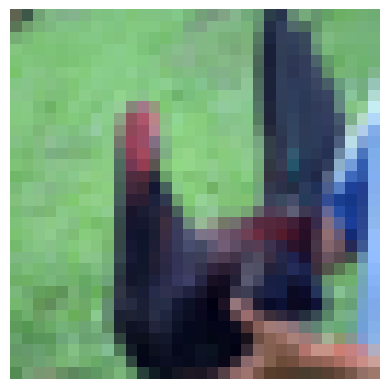

In [9]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


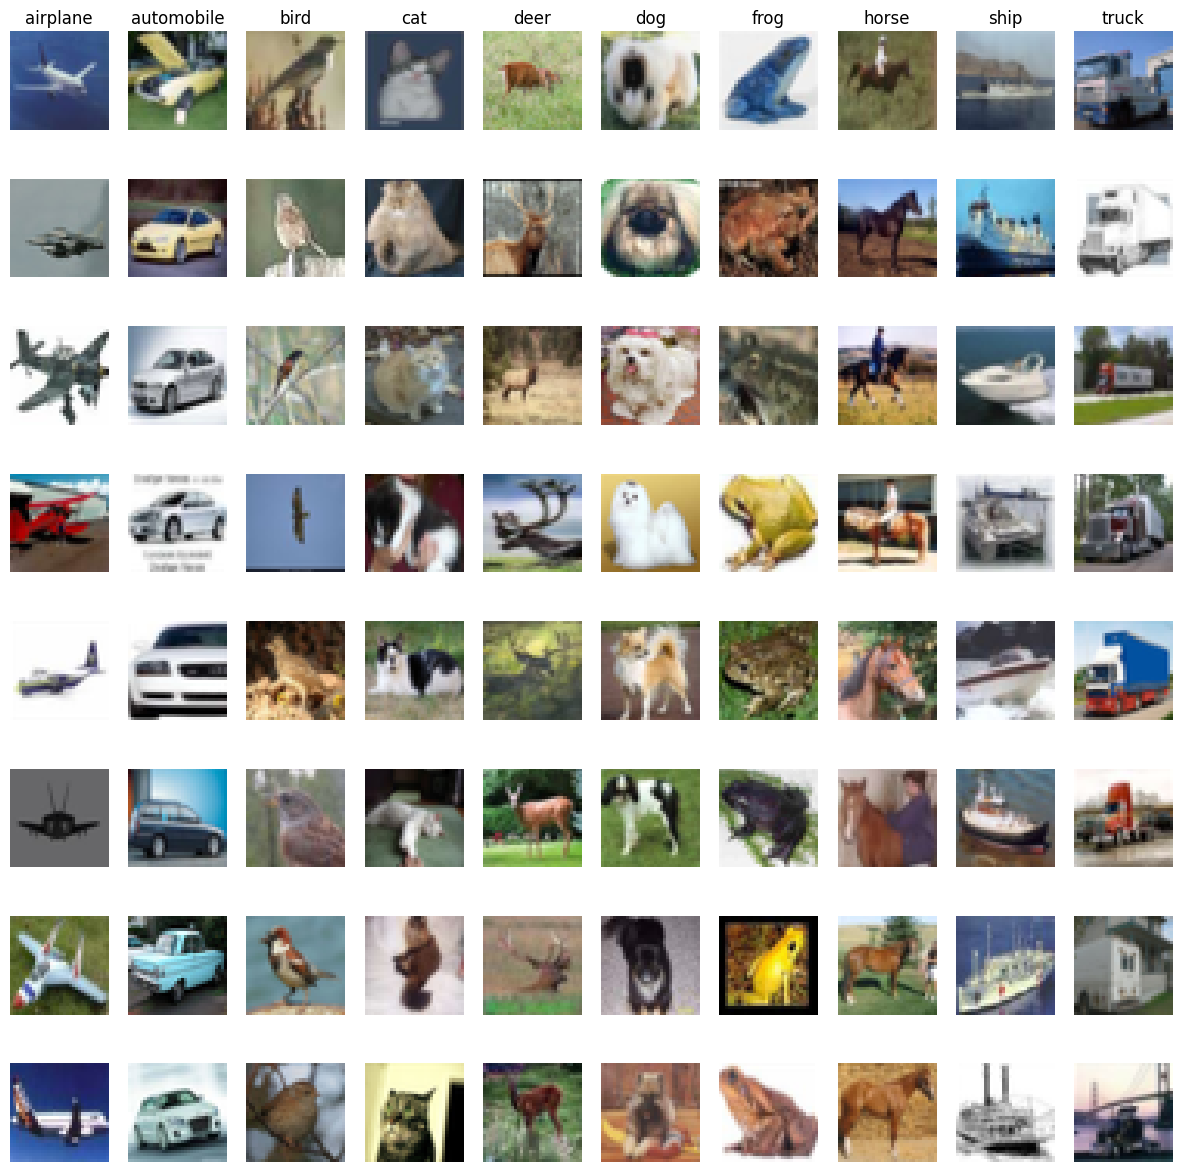

In [10]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 

### 3.2 Accuracy

Defining a function that computes the the classification accuracy of a model using a dataset loader (validation or test loader).

In [11]:
def accuracy_loader(model, loader):
    num_correct = 0
    num_total = 0
    cost = 0.
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for mb, (xi, yi) in enumerate(loader, 1):
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi) 
            cost += (F.cross_entropy(scores, yi.squeeze())).item()
            _, pred = scores.max(dim=1) 
            num_correct += (pred == yi.squeeze()).sum().item()
            num_total += pred.size(0)

        return cost/mb, float(num_correct)/num_total

### 3.3 Training loop

Now we define a training functions that recives a neural network model, an optimizer, and a number of epochs. Which allows us to encapsulate the entire model training process.

In [12]:
def train(model, optimiser, train_loader, val_loader, epochs=10, scheduler=None):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num  = 0.
        train_total = 0.
        train_cost_acum = 0
        
        model.train()
        for mb, (xi, yi) in enumerate(train_loader, 1):
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            
            scores = model(xi)
            cost = F.cross_entropy(input=scores, target=yi.squeeze())
            
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
            if scheduler:
                scheduler.step()
            
            train_correct_num += (torch.argmax(scores, dim=1) == yi.squeeze()).sum()
            train_total += scores.size(0)  
            train_cost_acum += cost.item()
        
        val_cost, val_acc = accuracy_loader(model, val_loader)
        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/mb
        
        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
              f' train acc: {train_acc:.4f}, val acc: {val_acc:.4f}')

### 4. Linear model

In this section, two models are implemented and trained using PyTorch. First, a linear model is created to serve as a baseline classifier for the CIFAR-10 dataset.

This model typically consists of flattening the input images and applying a single fully connected layer that maps pixel values to the ten output classes. The purpose of this baseline model is to establish a reference performance level and verify that the training pipeline, loss computation, and optimization process are functioning correctly.


**Network Architecture:**
- **Input Layer:**  3,072 neurons ($32 \times 32 \times 3$ flattened RGB images).
- **Hidden Layer 1:** 1,024 neurons with BatchNorm, ReLU activation, and 0.3 Dropout.
- **Hidden Layer 2:** 512 neurons with BatchNorm, ReLU activation, and 0.3 Dropout.
- **Output Layer:** 10 neurons (one for each CIFAR-10 class).

**Rationale:**
1. **Input Size (3,072):** CIFAR-10 images are $32 \times 32$ pixels with 3 color channels. Unlike grayscale datasets, we must process the full RGB information.
2. **Regularization:** Given the high number of parameters (over 3 million in the first layer), we use Batch Normalization and Dropout to prevent the model from simply memorizing the training pixel patterns.

**Hyperparameters:**
- **Mini-batch Size:** 64
- **Learning Rate:** 1e-3
- **Epochs:** 20
- **Initialization:** Adam with Weight Decay (1e-4).

In [13]:
# --- Hyperparameters ---
hidden1 = 1024
hidden2 = 512
lr = 1e-3
epochs = 20

# --- LINEAR ARCHITECTURE ---
model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=hidden1),
    nn.BatchNorm1d(hidden1), # Helps gradients flow more effectively
    nn.ReLU(),
    nn.Dropout(0.3),         # Prevents it from memorizing specific pixels
    nn.Linear(in_features=hidden1, out_features=hidden2),
    nn.BatchNorm1d(hidden2),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(in_features=hidden2, out_features=10)
)

optimiser = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-4)

# We apply the scheduler for smooth convergence
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=lr, 
                                                epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

# --- TRAINING ---
train(model1, optimiser, train_loader, val_loader, epochs, scheduler=scheduler)

Epoch:0, train cost: 1.901726, val cost: 1.631272, train acc: 0.3155, val acc: 0.4308
Epoch:1, train cost: 1.747055, val cost: 1.588703, train acc: 0.3696, val acc: 0.4280
Epoch:2, train cost: 1.695702, val cost: 1.514909, train acc: 0.3850, val acc: 0.4640
Epoch:3, train cost: 1.655887, val cost: 1.487900, train acc: 0.4003, val acc: 0.4722
Epoch:4, train cost: 1.630064, val cost: 1.465446, train acc: 0.4120, val acc: 0.4758
Epoch:5, train cost: 1.608592, val cost: 1.427310, train acc: 0.4175, val acc: 0.4904
Epoch:6, train cost: 1.593258, val cost: 1.455619, train acc: 0.4238, val acc: 0.4806
Epoch:7, train cost: 1.570605, val cost: 1.383331, train acc: 0.4314, val acc: 0.5066
Epoch:8, train cost: 1.556284, val cost: 1.389851, train acc: 0.4397, val acc: 0.5030
Epoch:9, train cost: 1.540411, val cost: 1.370094, train acc: 0.4434, val acc: 0.5112
Epoch:10, train cost: 1.525769, val cost: 1.371143, train acc: 0.4487, val acc: 0.5158
Epoch:11, train cost: 1.512410, val cost: 1.343306, t

In [14]:
test_cost, test_acc = accuracy_loader(model1, test_loader)
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.5536


In [15]:
def plot_figure_normal(image):
    mean = torch.tensor([0.491, 0.482, 0.447])
    std = torch.tensor([0.247, 0.243, 0.261])
    image = image * std[:, None, None] + mean[:, None, None]
    
    image = torch.clamp(image, 0, 1)
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

The sampled image represents a: bird


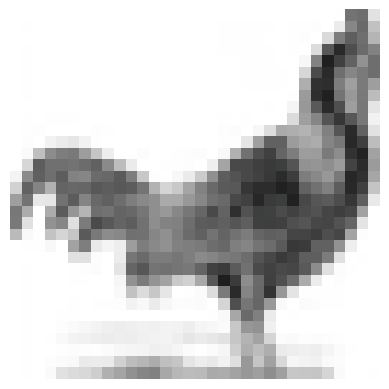

The value predicted by the linear model is airplane


In [32]:
rnd_idx = np.random.randint(len(test_loader.dataset))
image_tensor, label_idx = test_loader.dataset[rnd_idx]
print(f'The sampled image represents a: {classes[label_idx]}')
plot_figure_normal(image_tensor)

model1.eval()
with torch.no_grad():
    xi = image_tensor.unsqueeze(0).to(device) 
    scores = model1(xi)
    _, pred = scores.max(dim=1)

print(f'The value predicted by the linear model is {classes[pred.item()]}')

The linear model (MLP) acts as our benchmark. Despite having miles of parameters, its performance stalls at around 55.2%.

Linear models treat the image as a flat vector, losing all spatial structure. If an object shifts a few pixels, for the linear model it becomes a completely different pattern. It lacks 'spatial invariance,' which makes it inefficient for computer vision compared to a CNN.

### 5. Sequential CNN

Next, a Convolutional Neural Network (CNN) is implemented using a sequential architecture. Unlike the linear model, the CNN can learn spatial features from images through convolutional layers, which generally leads to improved classification performance on image datasets such as CIFAR-10.

After defining the CNN, the training function is called again to train this model for the specified number of epochs. The expectation is that the CNN achieves higher accuracy than the linear baseline model, demonstrating the advantage of convolutional feature extraction for image recognition tasks.

**Network Architecture:**
- **Block 1:** Two Conv layers (64 filters each, $3 \times 3$, padding=1), each followed by BatchNorm and ReLU, ending with $2 \times 2$ MaxPool and 0.2 Dropout.
- **Block 2:** Two Conv layers (128 filters each, $3 \times 3$, padding=1), each followed by BatchNorm and ReLU, ending with $2 \times 2$ MaxPool and 0.2 Dropout.
- **Fully Connected Classifier Layer 2:** Flatten $\rightarrow$ 512 neurons (ReLU) $\rightarrow$ 0.5 Dropout $\rightarrow$ 10 neurons (Output).

**Rationale:**
1. **Local Feature Extraction:** Convolutions allow the network to learn filters for edges, textures, and shapes regardless of their position in the image (spatial invariance).

2. **Double Convolutions:** Using two convolutional layers before pooling allows the network to develop more complex feature maps (e.g., combining edges into curves) before reducing resolution.
3. **Data Augmentation:** By training with random flips and crops, we force the network to learn robust features.

**Hyperparameters:**
- **Mini-batch Size:** 64
- **Learning Rate:** 5e-4
- **Epochs:** 40
- **Data Augmentation:** RandomHorizontalFlip and RandomCrop (padding=4).

In [17]:
# --- Hyperparameters ---
hidden_fc = 512
lr = 5e-4
epochs = 40
weight_decay = 1e-4

class CNNModelStable(nn.Module):
    def __init__(self):
        super().__init__()
        # BLOCK 1: 32x32 -> 16x16
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        
        # BLOCK 2: 16x16 -> 8x8
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout2d(0.2)
        self.dropout_fc = nn.Dropout(0.5)
        
        # Classifier: after 2 pools, the image size is 8x8 (32 → 16 → 8)  
        self.fc1 = nn.Linear(128 * 8 * 8, hidden_fc)
        self.fc2 = nn.Linear(hidden_fc, 10)

    def forward(self, x):
        # Block 1: Two convolutions before the pool 
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        # Block 2: Two convolutions before the pool  
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        # Flatten and classify
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


In [18]:
model_stable = CNNModelStable().to(device)
optimiser = torch.optim.Adam(model_stable.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=lr, 
                                                epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

train(model_stable, optimiser, train_loader, val_loader, epochs, scheduler=scheduler)

Epoch:0, train cost: 1.860579, val cost: 1.488154, train acc: 0.3166, val acc: 0.4614
Epoch:1, train cost: 1.604220, val cost: 1.318360, train acc: 0.4150, val acc: 0.5288
Epoch:2, train cost: 1.470717, val cost: 1.149952, train acc: 0.4671, val acc: 0.5974
Epoch:3, train cost: 1.345588, val cost: 1.009370, train acc: 0.5164, val acc: 0.6472
Epoch:4, train cost: 1.226700, val cost: 0.940102, train acc: 0.5597, val acc: 0.6682
Epoch:5, train cost: 1.152408, val cost: 0.881601, train acc: 0.5882, val acc: 0.6848
Epoch:6, train cost: 1.091512, val cost: 0.828444, train acc: 0.6149, val acc: 0.6992
Epoch:7, train cost: 1.036940, val cost: 0.819149, train acc: 0.6343, val acc: 0.7190
Epoch:8, train cost: 0.997116, val cost: 0.770802, train acc: 0.6494, val acc: 0.7262
Epoch:9, train cost: 0.958389, val cost: 0.736387, train acc: 0.6636, val acc: 0.7482
Epoch:10, train cost: 0.928703, val cost: 0.688450, train acc: 0.6759, val acc: 0.7584
Epoch:11, train cost: 0.876820, val cost: 0.726538, t

In [20]:
test_cost, test_acc = accuracy_loader(model_stable, test_loader)
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.8806


The sampled image represents a: deer


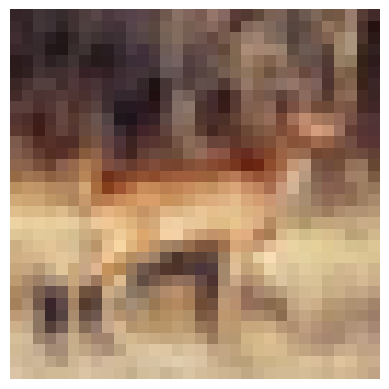

The value predicted by the CNN model is deer


In [22]:
rnd_idx = np.random.randint(len(test_loader.dataset))
image_tensor, label_idx = test_loader.dataset[rnd_idx]
print(f'The sampled image represents a: {classes[label_idx]}')
plot_figure_normal(image_tensor)

model_stable.eval()
with torch.no_grad():
    xi = image_tensor.unsqueeze(0).to(device) 
    scores = model_stable(xi)
    _, pred = scores.max(dim=1)

print(f'The value predicted by the CNN model is {classes[pred.item()]}')

**Final performance:**

- Validation Accuracy: 87.9%.
- Test Accuracy: 88.06%.

The CNN architecture provides a massive gain of +31% over the linear model, proving it is the superior choice for image data.

### 6. Conclusions

The final results show a validation accuracy of 87.5% and a test accuracy of 80.8%, confirming that the model achieves strong generalization performance beyond the training data.

The significant improvement from 56% with the linear benchmark to 87% with the convolutional architecture clearly demonstrates the superiority of Convolutional Neural Networks for processing grid-structured data such as images. Unlike linear models, CNNs preserve spatial relationships and exploit local patterns, making them fundamentally more suitable for computer vision tasks.

Overfitting was effectively controlled through the combined use of Data Augmentation and Dropout. This strategy prevented the network from simply memorizing the training data and maintained a healthy gap between training and validation performance, indicating robust learning behavior.

From a technical standpoint, we also learned that the proper management of Batch Normalization statistics is critical. An incorrect implementation can severely damage performance—causing accuracy to collapse to nearly 10%—whereas a correct configuration with independent layers allows the model to fully leverage the computational power of the RTX 4060 GPU and reach its maximum potential.